In [ ]:
'''
Deep Learning Stock Price Predictor 
Author: Gil Akos
Objective: Create Benchmark Model with scikit learn regression
'''

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Import required libraries for Machine Learning
import math
import numpy as np
import pandas as pd
# Use alternate model type
from sklearn.linear_model import (LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor)
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# Import required libraries for Yahoo Finance API
import yahoo_finance as yf
from yahoo_finance import Share

# Import required libraries for visualization and printing
from pprint import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18, 12)
import matplotlib.dates as mdates

# Import utility libraries
import utilities as util
import datetime

In [39]:
# Set Benchmark Dates based on Machine Learning for Trading course 1/1/09-6/18/15
date_start, date_end = '1995-01-01', '2015-06-18'

# Set Additional Tickers
tick_0 = 'SPY'
tick_1 = 'GE'
tick_2 = 'MSFT'
tick_3 = 'AAPL'

# Set Baseline Model Ticker
base_ticker = tick_2

In [40]:
#Request Stock Data
stock_data = Share(base_ticker)
stock_historical = stock_data.get_historical(date_start,date_end)

#pprint(stock_historical)

#Define columns of data to keep from historical stock data
stock_item = []
stock_date = []
stock_close = []
stock_volume = []

#Loop through the stock data objects backwards and store factors we want to keep
i_counter = 0
for i in xrange(len(stock_historical)-1,-1,-1):
    d = stock_historical[i]
    stock_item.append(i_counter)
    stock_date.append(d['Date'])
    stock_close.append(d['Adj_Close'])
    stock_volume.append(d['Volume'])
    i_counter += 1

#Create a dataframe for stock data
stock_df = pd.DataFrame()
    
#Add factors to dataframe
stock_df['Item'] = stock_item
stock_df['Date'] = stock_date
stock_df['Adj_Close'] = pd.to_numeric(stock_close)
stock_df['Volume'] = pd.to_numeric(stock_volume)

#Print the dataframe head and tail
print(stock_df.head())
print("---")
print(stock_df.tail())

   Item        Date  Adj_Close    Volume
0     0  1995-01-03   2.538824  39545600
1     1  1995-01-04   2.557278  51611200
2     2  1995-01-05   2.515096  39824000
3     3  1995-01-06   2.557278  46681600
4     4  1995-01-09   2.541460  46000000
---
      Item        Date  Adj_Close    Volume
5147  5147  2015-06-12  43.885499  23931000
5148  5148  2015-06-15  43.417717  33254500
5149  5149  2015-06-16  43.751848  27070300
5150  5150  2015-06-17  43.885499  28704100
5151  5151  2015-06-18  44.601491  32658300


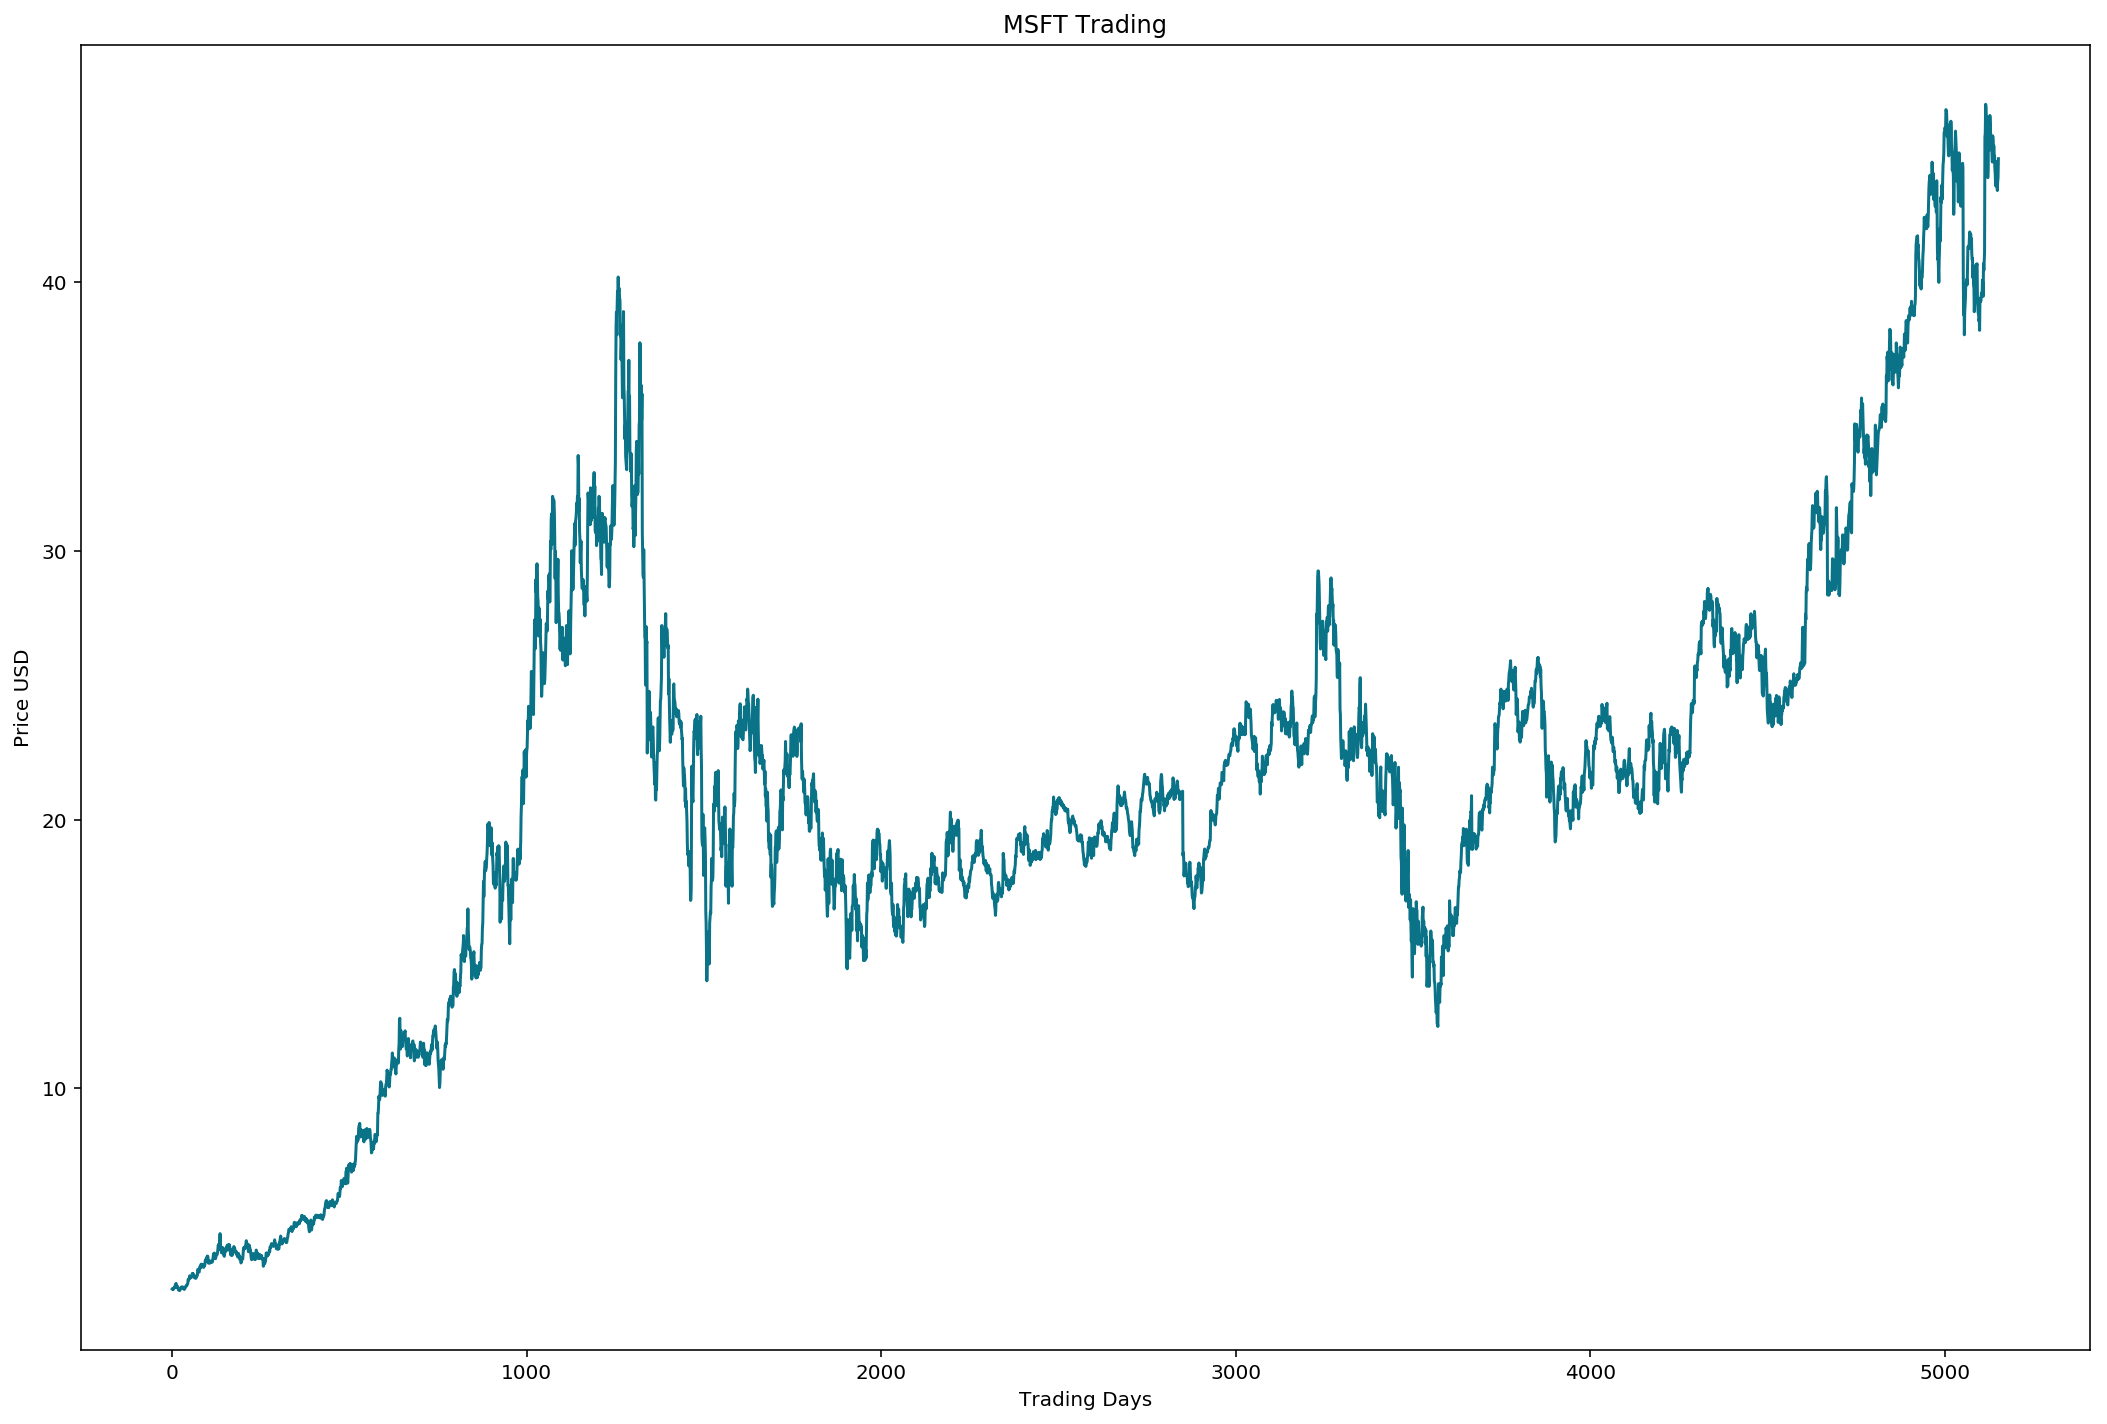

In [41]:
#Plot Basic Data
fig, ax = plt.subplots()
ax.plot(stock_df['Item'], stock_df['Adj_Close'], '#0A7388')

# format the coords message box
def price(x):
    return '$%1.2f' % x
#ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = price
ax.set_title(base_ticker + ' Trading')

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')

plt.show()

In [42]:
#Create numpy arrays for features and targets
X_all = []
y_all = []

#Convert dataframe columns to numpy arrays for scikit learn
for index, row in stock_df.iterrows():
    #print([np.array(row['Item'])])
    X_all.append([(row['Item'])])
    y_all.append([(row['Adj_Close'])])

#pprint(X_all)
pprint(y_all)

[[2.538824],
 [2.5572779999999997],
 [2.5150959999999998],
 [2.5572779999999997],
 [2.54146],
 [2.573096],
 [2.588915],
 [2.5836419999999998],
 [2.6469150000000004],
 [2.704915],
 [2.726006],
 [2.7444599999999997],
 [2.6785509999999997],
 [2.5994599999999997],
 [2.6495509999999998],
 [2.615936],
 [2.604733],
 [2.525642],
 [2.525642],
 [2.4887330000000003],
 [2.5045509999999997],
 [2.494005],
 [2.4887330000000003],
 [2.536187],
 [2.5678240000000003],
 [2.573096],
 [2.6100060000000003],
 [2.6100060000000003],
 [2.615278],
 [2.615278],
 [2.6100060000000003],
 [2.562551],
 [2.5678240000000003],
 [2.546733],
 [2.520369],
 [2.594187],
 [2.5994599999999997],
 [2.5836419999999998],
 [2.604733],
 [2.65746],
 [2.668006],
 [2.6890970000000003],
 [2.683824],
 [2.7128240000000003],
 [2.756322],
 [2.8894610000000003],
 [2.8630970000000002],
 [2.892097],
 [2.910552],
 [3.026552],
 [2.973825],
 [2.958006],
 [2.950097],
 [3.000188],
 [2.971188],
 [2.992279],
 [3.068734],
 [3.116189],
 [3.079279],
 [3.1

In [43]:
# Regularize the feature and target arrays and store min/max of input data for rescaling later
X_bounds = [min(X_all), max(X_all)]
X_bounds = [X_bounds[0][0], X_bounds[1][0]]
y_bounds = [min(y_all), max(y_all)]
y_bounds = [y_bounds[0][0], y_bounds[1][0]]

X_scaled, X_range = util.scale_range(np.array(X_all), input_range=X_bounds, target_range=[-1.0, 1.0])
y_scaled, y_range = util.scale_range(np.array(y_all), input_range=y_bounds, target_range=[-1.0, 1.0])

pprint(y_scaled)
print(y_range)

array([[-0.99773031],
       [-0.99689414],
       [-0.99880546],
       ..., 
       [ 0.8696861 ],
       [ 0.875742  ],
       [ 0.90818454]])
[2.4887330000000003, 46.627815999999996]


In [44]:
# Define Test/Train Split 80/20
tt_split = .315
tti_split = int(math.floor(len(stock_df['Item'])*tt_split))

# Set up training and test sets
X_train = X_scaled[:-tti_split]
X_test = X_scaled[-tti_split:]

y_train = y_scaled[:-tti_split]
y_test = y_scaled[-tti_split:]

#pprint(X_train)
#pprint(X_test)

# Create dataframe for all training, testing, and predicted sets
results_df = pd.DataFrame(columns=['Item', 'Actual', 'Actual_Scaled', 'Train', 'Test', 'Test_Scaled', 'Predicted', 'Predicted_Scaled'])
results_df['Item'] = stock_df['Item']
results_df['Actual'] = stock_df['Adj_Close']
results_df['Actual_Scaled'] = y_scaled.flatten()
results_df['Train'][:-tti_split] = y_train.flatten()
results_df['Test'][-tti_split:] = stock_df['Adj_Close'][-tti_split:]
results_df['Test_Scaled'][-tti_split:] = y_test.flatten()

pprint(results_df)


      Item     Actual  Actual_Scaled     Train     Test Test_Scaled Predicted  \
0        0   2.538824      -0.997730  -0.99773      NaN         NaN       NaN   
1        1   2.557278      -0.996894 -0.996894      NaN         NaN       NaN   
2        2   2.515096      -0.998805 -0.998805      NaN         NaN       NaN   
3        3   2.557278      -0.996894 -0.996894      NaN         NaN       NaN   
4        4   2.541460      -0.997611 -0.997611      NaN         NaN       NaN   
5        5   2.573096      -0.996177 -0.996177      NaN         NaN       NaN   
6        6   2.588915      -0.995461 -0.995461      NaN         NaN       NaN   
7        7   2.583642      -0.995700   -0.9957      NaN         NaN       NaN   
8        8   2.646915      -0.992833 -0.992833      NaN         NaN       NaN   
9        9   2.704915      -0.990205 -0.990205      NaN         NaN       NaN   
10      10   2.726006      -0.989249 -0.989249      NaN         NaN       NaN   
11      11   2.744460      -

/Users/gilakos/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/gilakos/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/gilakos/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [45]:
# Create polynomial regression object
# http://scikit-learn.org/stable/auto_examples/linear_model/plot_robust_fit.html
model = make_pipeline(PolynomialFeatures(2), TheilSenRegressor(random_state=17))

# Train the model using the training sets
model.fit(X_train, y_train)

pprint(X_test)
# Create the predictions
initial_predictions = model.predict(X_test)
# Convert to correct numpy datastructure
predictions = []
for p in initial_predictions:
    predictions.append([p])
predictions = np.asarray(predictions)
#pprint(predictions)

predictions_rescaled, re_range = util.scale_range(predictions, input_range=[-1.0,1.0], target_range=y_range)
print(re_range)
print(predictions)
print(predictions_rescaled)

# Store the predictions
results_df['Predicted_Scaled'][-tti_split:] = predictions.flatten()
results_df['Predicted'][-tti_split:] = predictions_rescaled.flatten()

pprint(results_df)

array([[ 0.37060765],
       [ 0.37099592],
       [ 0.3713842 ],
       ..., 
       [ 0.99922345],
       [ 0.99961173],
       [ 1.        ]])
[-1.1209956157617902, -0.31726805861129875]
[[-0.31726806]
 [-0.31755797]
 [-0.31784814]
 ..., 
 [-1.11959241]
 [-1.12029388]
 [-1.12099562]]
[[ 17.55631391]
 [ 17.54991566]
 [ 17.5435118 ]
 ..., 
 [ -0.15061661]
 [ -0.16609788]
 [ -0.18158476]]
      Item     Actual  Actual_Scaled     Train     Test Test_Scaled  \
0        0   2.538824      -0.997730  -0.99773      NaN         NaN   
1        1   2.557278      -0.996894 -0.996894      NaN         NaN   
2        2   2.515096      -0.998805 -0.998805      NaN         NaN   
3        3   2.557278      -0.996894 -0.996894      NaN         NaN   
4        4   2.541460      -0.997611 -0.997611      NaN         NaN   
5        5   2.573096      -0.996177 -0.996177      NaN         NaN   
6        6   2.588915      -0.995461 -0.995461      NaN         NaN   
7        7   2.583642      -0.995700   -

/Users/gilakos/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/gilakos/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


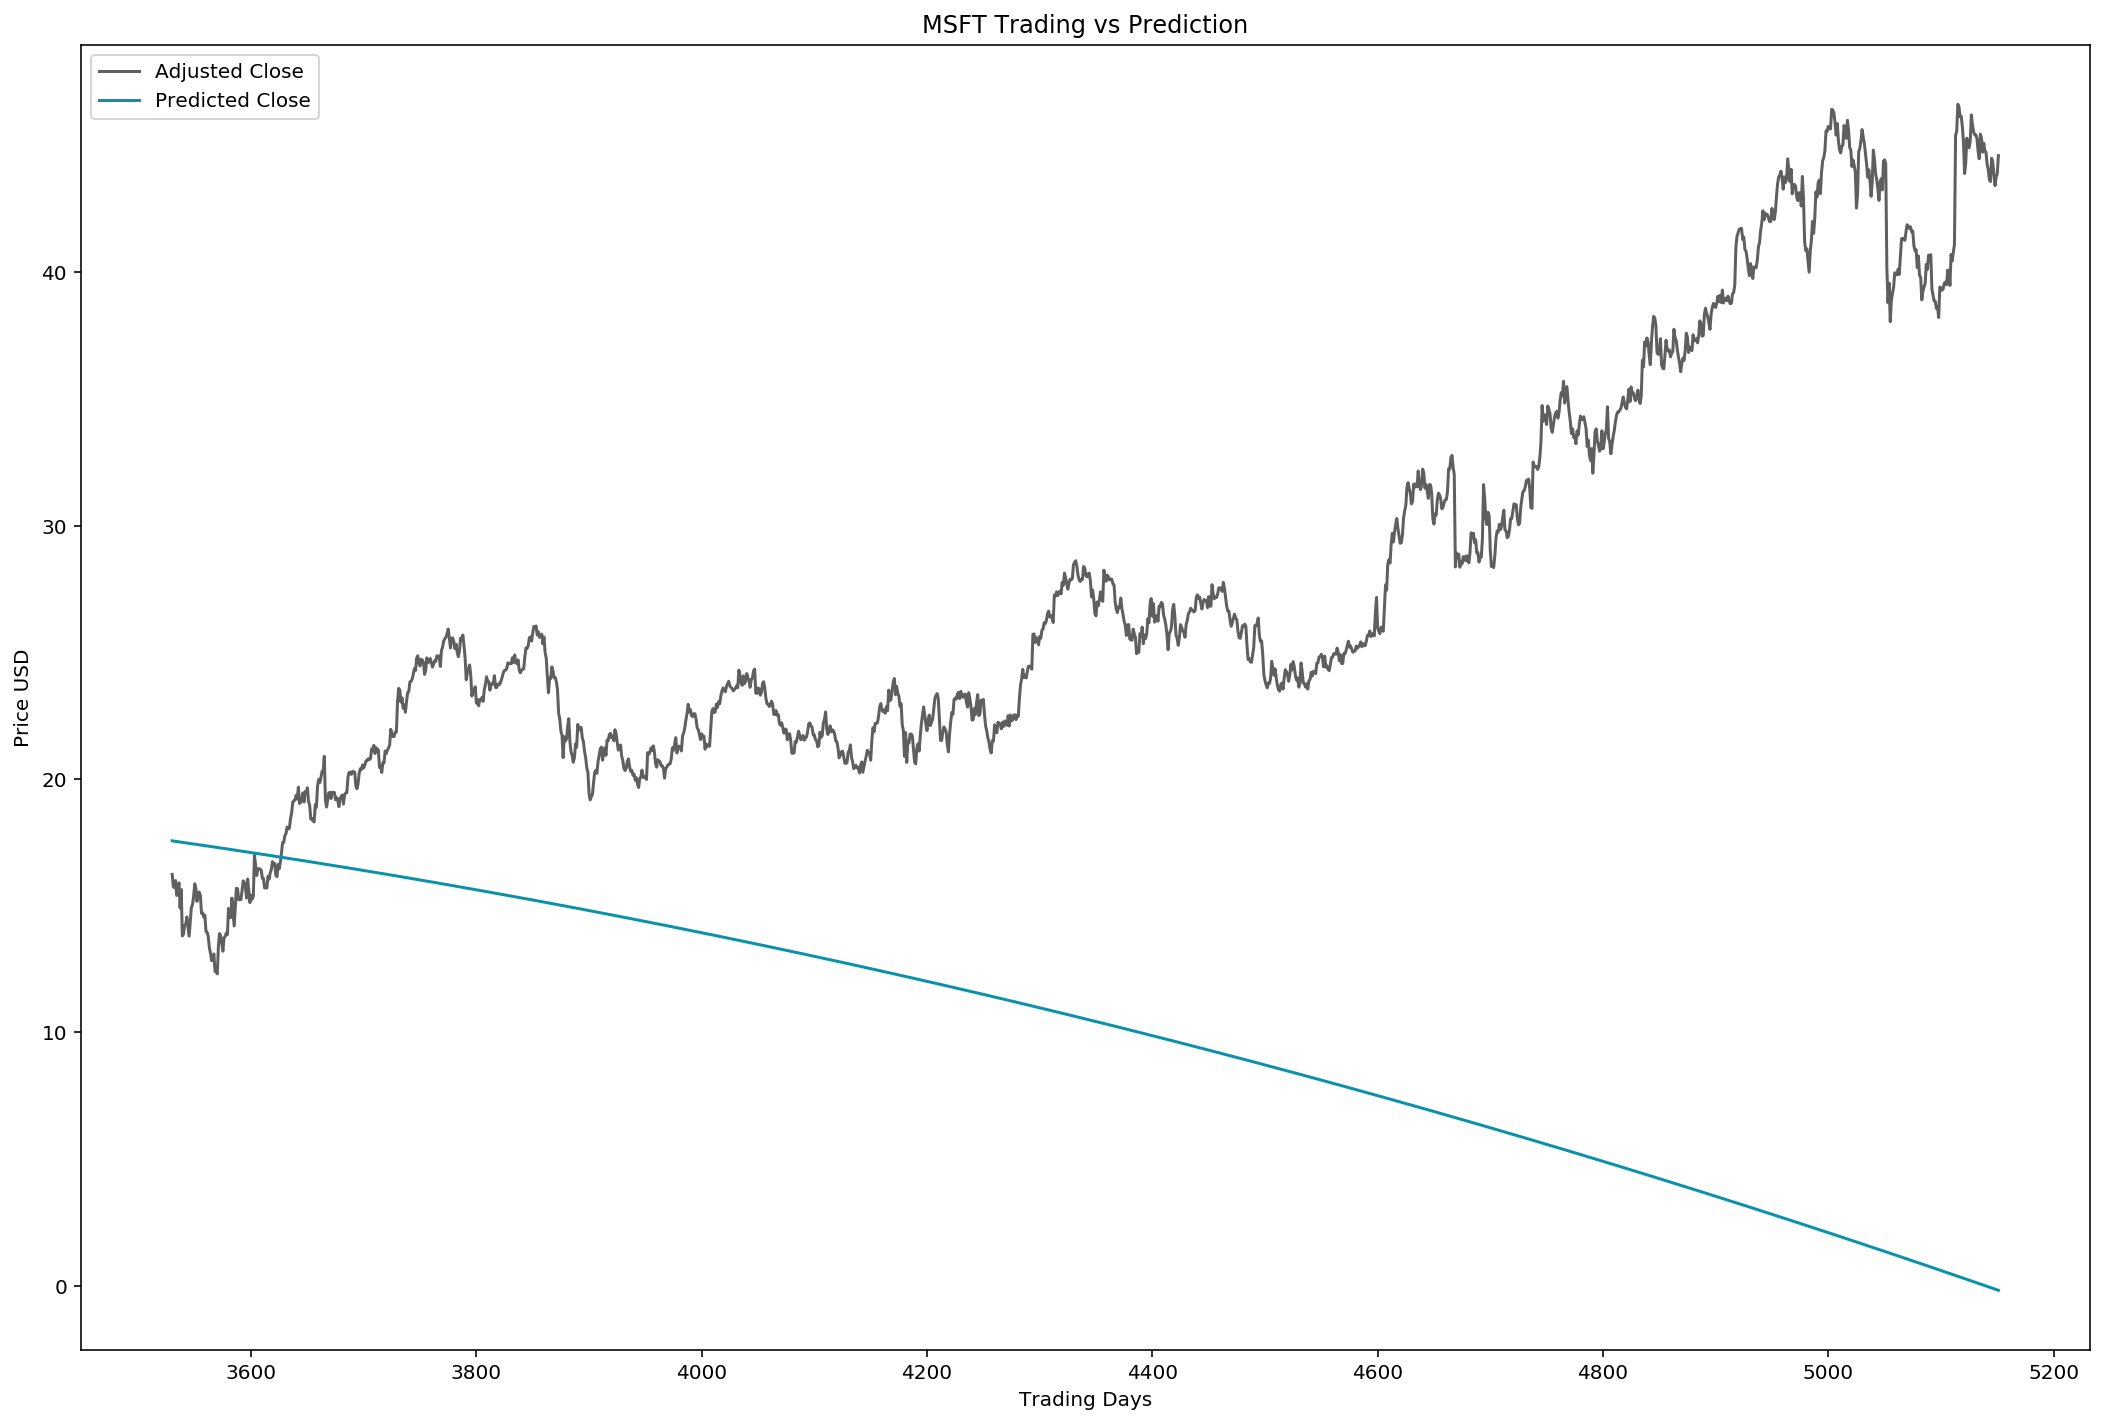

In [46]:
# Plot the training, testing, and predicted data

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

plt.plot(results_df['Test'],'#5F5F5F', label='Adjusted Close')
plt.plot(results_df['Predicted'], '#0C91AB', label='Predicted Close')

# Set title
ax.set_title(base_ticker + ' Trading vs Prediction')
ax.legend(loc='upper left')

plt.show()

In [47]:
# The mean squared error
testScore = mean_squared_error(predictions, y_test)
print('Test Score: %.4f MSE (%.4f RMSE)' % (testScore, math.sqrt(testScore)))

Test Score: 0.9899 MSE (0.9949 RMSE)


# Log of Results:

### SPY
Test Score: 0.3895 MSE (0.6241 RMSE)

### GE
Test Score: 0.8083 MSE (0.8991 RMSE)

### MSFT
Test Score: 0.9899 MSE (0.9949 RMSE)

### AAPL
Test Score: 0.3034 MSE (0.5509 RMSE)
